# Финальный проект: Мобильные приложения — Выделение групп пользователей на основе поведения

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

В ходе проекта я сегметировала пользователей на основании времени, проведенному на сайте, удержания и конверсии в целевое действие(просмотр контактов покупателя).

## Материалы:

 - [Презентация](https://drive.google.com/file/d/1eQfIOOv5EyAsLwJDf1IZGDZhKF0g6UwD/view?usp=sharing)
 - [Дашборд](https://public.tableau.com/views/final_project_16509789794970/final_project?:language=en-US&:display_count=n&:origin=viz_share_link)

## Открытие данных

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st
import math

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
try:
    data = pd.read_csv('/Users/air/Downloads/mobile_dataset.csv')
    sources = pd.read_csv('/Users/air/Downloads/mobile_soures.csv')
except:
    data = pd.read_csv('/datasets/mobile_dataset.csv')
    sources = pd.read_csv('/datasets/mobile_soures.csv')

In [58]:
data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [59]:
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Датасет **mobile_dataset.csv** содержит колонки:
 - event.time — время совершения
 - event.name — название события
 - user.id — идентификатор пользователя
 
Датасет **mobile_sources.csv** содержит колонки:
 - userId — идентификатор пользователя
 - source — источник, с которого пользователь установил приложение
 

## Предобработка данных

Изменим названия колонок в таблицах:

In [60]:
data.columns = ['event_time', 'event_name', 'user_id']

In [61]:
sources.columns = ['user_id', 'source']

In [62]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [63]:
# Избавимся от дублирующих наименований show_contacts и contacts_show
data.loc[data['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

### Пропуски

In [64]:
data.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [65]:
sources.isna().sum()

user_id    0
source     0
dtype: int64

**Вывод:** Пропущенных значений а данных не обнаружено.

### Дубликаты

In [66]:
sources.duplicated().sum()

0

In [67]:
data.duplicated().sum()

0

**Вывод:** Дубликатов в данных не обнаружено.

### Изменение типов данных

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Приведем столбец с датой посещения в формату datetime:

In [69]:
data['event_time'] = pd.to_datetime(data['event_time'])

# Удалим занчения милисекунд
data['event_time'] = data['event_time'].dt.floor('S')

In [70]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


### Добавление значений в данные

Добавим в таблицу:
 - дату посещения сайта без информации о времени
 - время начала сессии
 - время окончания сессии

In [71]:
# Добавим дату пользования мобильным приложением
data['dt'] = data['event_time'].dt.date

In [72]:
data.groupby(['user_id', 'dt']).agg({'event_name':'count'}).head(5)

event_name
user_id                              dt                    
0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-07           9
                                     2019-10-09           4
                                     2019-10-21          14
                                     2019-10-22           8
00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-19           9

Как мы видим, в день пользователи совершают несколько действий на сайте. В дальнейшем я делаю допущение, что в день у пользователя только одна сессия. Исходя из этого я посчитаю начало и конец этой сессии.

Основной минус данного решения заключается в том, что некоторые пользователи заходят в приложение несколько раз за день, следовательно, длительность сессии, а также ее начало и конец будут вычислены некорретно для этих пользователей.

In [73]:
# Надем начало сессии
session_start = (
    data.sort_values(by=['user_id', 'dt'])
    .groupby(['user_id', 'dt'])
    .agg({'event_time':'first'})
    .rename(columns = {'event_time':'session_start'})
    .reset_index()
)

# Добавим эти данные в основную таблицу
data = data.merge(session_start, on = ['user_id', 'dt'])

In [74]:
# Вычислим окончание сессии
session_end = (
    data.sort_values(by=['user_id', 'dt'])
    .groupby(['user_id', 'dt'])
    .agg({'event_time':'last'})
    .rename(columns = {'event_time':'session_end'})
    .reset_index()
)

# Добавим эти данные в основную таблицу
data = data.merge(session_end, on = ['user_id', 'dt'])

**Вывод:**

 - Дубликтов и пропусков в данных не обнаружено
 - Данные в столбце с датой и временем события приведены к формату datetime, были удалены милисекунды
 - Были добавлены новые значения: дата совершения действия, время начала и окончания сессии.

## Исследовательский анализ данных

### Распределение данных по времени


#### Период, за который представлены данные

In [75]:
data.event_time.min()

Timestamp('2019-10-07 00:00:00')

In [76]:
data.event_time.max()

Timestamp('2019-11-03 23:58:12')

**Вывод:** Данные представлены примерно за один месяц: с 7 октября 2019 года по 3 ноября 2019 года.

#### Распределение событий по времени

In [77]:
# Функция для построения графика
def make_barplot(e1, e2):
    
    sns.barplot(
        data = data.groupby(e1).agg({e2:'count'}).reset_index(),
        x = e1,
        y = e2,
        color='pink'
    )

Text(0, 0.5, 'Количество действий')

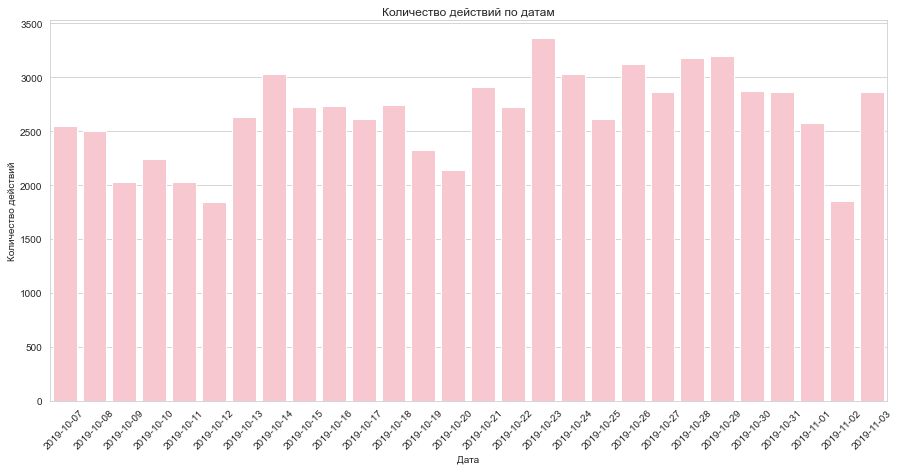

In [78]:
# Установим размер графика
plt.figure(figsize = (15,7))

# Добавим разметку
sns.set_style("whitegrid")


make_barplot('dt', 'user_id')

plt.xticks(rotation=45)
plt.title('Количество действий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество действий')

Text(0.5, 0, 'Номер недели')

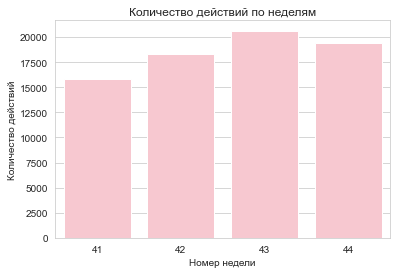

In [79]:
# Добавим колонку с номером недели
data['session_week'] = data['event_time'].dt.isocalendar().week

make_barplot('session_week', 'user_id')
plt.title('Количество действий по неделям')
plt.ylabel('Количество действий')
plt.xlabel('Номер недели')

**Вывод:** Как мы видим, распределение данных по датам неравномерное. C 7 по 12 октября оно колеблется между 1700 и 2500 действий, с 13 по 20 октября - это 2000-3000 действий, c 21 - это 2500+ действий в день.

Если посмотреть на распределение данных по неделям, то мы видим равномерный подъем с 1 по 3 неделю, на 4 неделе мы наблюдает незначительный спад активности. Скорее всего это связано с резким снижением активности 2 ноября, стоит учитывать, что это приближающиеся праздничные выходные. 

#### Распределение событий по дням недели

Text(0, 0.5, 'Количество действий')

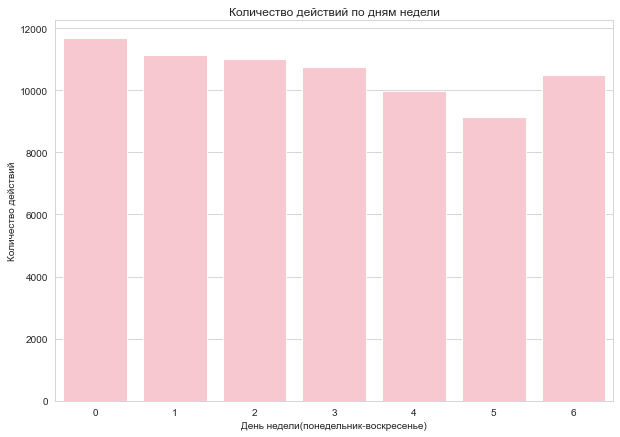

In [80]:
# Добавим строку, которая определяет день недели
data['day_of_the_week'] = data['event_time'].apply(lambda time: time.dayofweek)

plt.figure(figsize = (10,7))
make_barplot('day_of_the_week', 'user_id')

plt.title('Количество действий по дням недели')
plt.xlabel('День недели(понедельник-воскресенье)')
plt.ylabel('Количество действий')

Действительно, наибольшая активность наблюдается в начале недели, затем идет плавный спад. Наименьшая активность наблюдается в субботу. 

#### DAU и WAU

In [81]:
# Посчитаем DAU и WAU
print('DAU:', int(data.groupby('dt').agg({'user_id': 'nunique'}).mean()))
print('WAU:', int(data.groupby('session_week').agg({'user_id':'nunique'}).mean()))

DAU: 279
WAU: 1382


Text(0, 0.5, 'Количество пользователей')

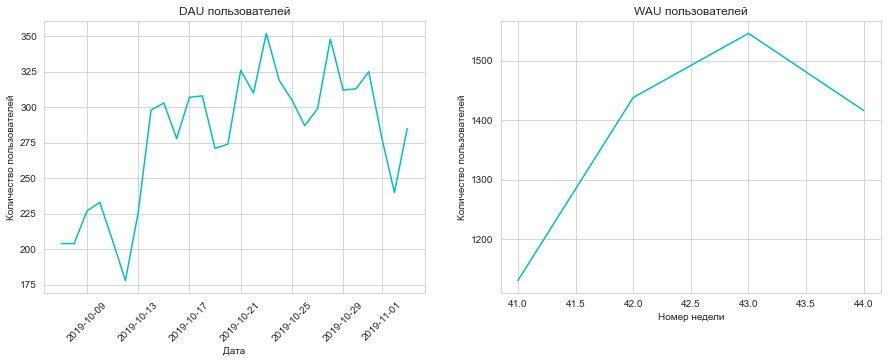

In [82]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(data.groupby('dt').agg({'user_id':'nunique'}), color='c')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('DAU пользователей')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Количество пользователей')


axes[1].plot(data.groupby('session_week').agg({'user_id':'nunique'}), color='c')
axes[1].set_title('WAU пользователей')
axes[1].set_xlabel('Номер недели')
axes[1].set_ylabel('Количество пользователей')

In [83]:
data = data.drop(columns = ['session_week', 'day_of_the_week'])

#### Вывод:

 - Данные представлены за период с 10 октября по 3 ноября. 
 - Первые три недели представленных данных активность пользователей увеличивается, затем наблюдается незначительный спад, однако видна положительная динамика. 
 - В течение недели наблюдается спад активности к выходным(суббота/воскресенье).
 - Среднее количество пользователей в день - 279, в неделю - 1382

### Распределение данных по событиям

#### Распределение событий по типам

<function matplotlib.pyplot.yticks(ticks=None, labels=None, **kwargs)>

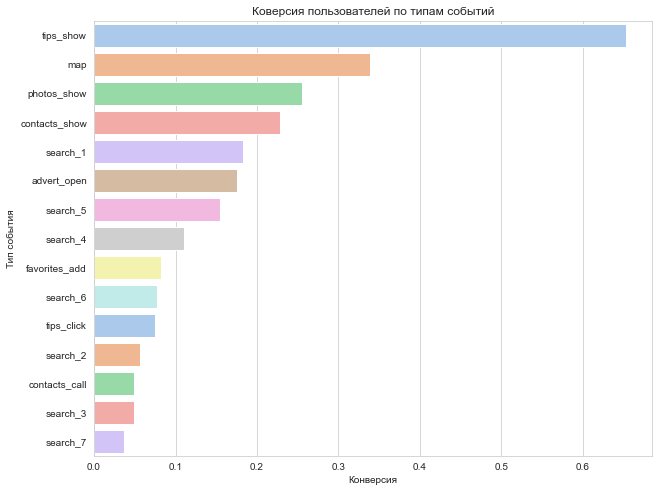

In [84]:
# Создадим таблицу, в которой будут отобрадаться количество уникальных пользователей, совершивших разные типы событий
report = (
    data.groupby('event_name')
    .agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)

# Найдем конверсию для каждого типа события от общего числа пользователей
report['conversion'] = report['user_id'] / data.user_id.nunique()


plt.figure(figsize = (10,8))
sns.barplot(
    data = report,
    x = 'conversion',
    y = 'event_name',
    palette = 'pastel'  
)

plt.title('Коверсия пользователей по типам событий')
plt.xlabel('Конверсия')
plt.ylabel('Тип события')
plt.yticks

**Вывод:** 
 - Как мы видим на графике, наиболее частое событие - показ рекомендованных объявлений. Как я понимаю, это первое, что видит пользователь при входе в приложение, более 60% совершают это действие.
 - Открывают карту примерно 34% пользователей и примерно 25% просматривают фотографии объявлений.
 - Как мне кажется, события в приложении не выстраиваются в четкую воронку: к показу контактов(целевому действию) можно прийти как через рекомендованное объявление, так и через один из поисков, так и через карту.
 - Целевое действие(показ контактов продавца) совершают примерно 23% пользователей.

#### Распределение событий на пользователей

Text(0.5, 0, 'Количество действий')

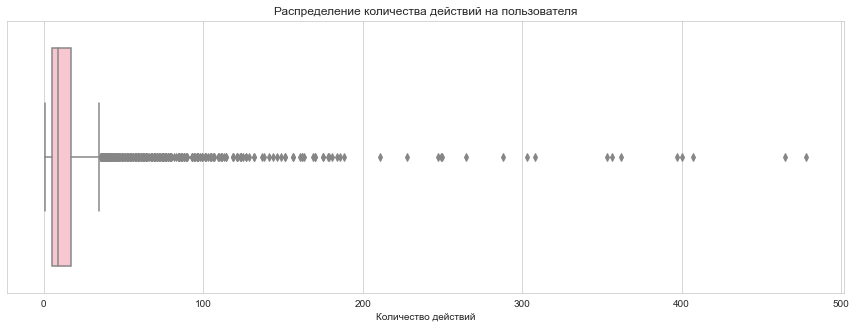

In [85]:
# Сгруппируем данные по имени пользователя и найдем количество событий
report = data.groupby('user_id').agg({'event_name':'count'})

plt.figure(figsize=(15,5))
sns.boxplot(x = report['event_name'], color = 'pink')
plt.title('Распределение количества действий на пользователя')
plt.xlabel('Количество действий')

На диаграмме размаха видно, что в данных много выбросов: например пользователи, которые совершали 100+ действий. 

In [86]:
report = report.reset_index()

# Найдем id пользователей, которые совершили более 100 действий
report2 = report[report['event_name'] > 100]['user_id'].unique()

# Посчитаем процент данных, которые совершили пользователи со 100+ действиями
data.query('user_id in @report2').count() / data.count()

event_time       0.18273
event_name       0.18273
user_id          0.18273
dt               0.18273
session_start    0.18273
session_end      0.18273
dtype: float64

Данные пользователи составляют примерно 18% всех данных. Это достаточно большой процент, поэтому мы просто оставим этих пользователей в таблице, но будем учитывать, что они могут создавать выбросы в данных.

In [87]:
print('Среднее количество событий на пользователя: {:.2f}'.format(report['event_name'].mean()))
print('Медианное количество событий на пользователя: {:.2f}'.format(report['event_name'].median()))

Среднее количество событий на пользователя: 17.28
Медианное количество событий на пользователя: 9.00


#### Вывод:

 - События в мобильном приложении не выстраиваются в воронку, связь между событиями непоследовательная.
 - Целевое действие(показ контактов продавца) совершают примерно 23% пользователей.
 - Есть уникальные пользователи, совершившие за месяц более 100 действий.
 - Среднее количество событий на пользователя - 17, медианное - 9.

### Распределение по источникам

#### Количество пользователей по источникам

In [88]:
# Прицепим данные об источниках к основной таблице
data = data.merge(sources, on='user_id')

Text(0.5, 1.0, 'Процентное соотношение пользователей по источникам')

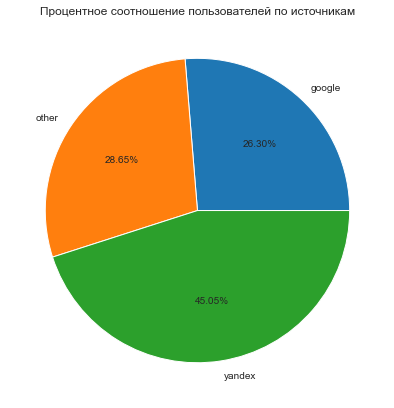

In [89]:
# Сгруппируем данные по источникам
users_by_sources = sources.groupby('source').agg({'user_id':'nunique'}).reset_index()

# Добавим столбец с процентным соотношением пользователей по источникам
users_by_sources['perc'] = users_by_sources['user_id'] / sources.user_id.nunique()

plt.figure(figsize=(7,7))
plt.pie(users_by_sources['perc'], labels = users_by_sources['source'], autopct='%.2f%%')
plt.title('Процентное соотношение пользователей по источникам')

**Вывод:** Примерно 45% пользователей приходят в приложение через Яндекс, 26% через Google и примерно 28% через другие источники.

#### Количество событий по источника

Text(0, 0.5, 'Количество событий')

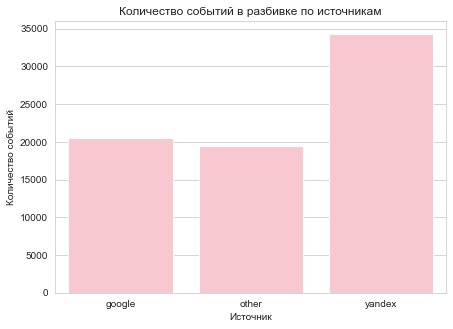

In [90]:
plt.figure(figsize = (7,5))

make_barplot('source', 'event_name')
plt.title('Количество событий в разбивке по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество событий')

**Вывод:** Пользователи, пришедшие из Яндекса совершили в целом больше действий, чем пользователи, пришедшие из других источников.

In [91]:
# Сгруппируем данные по источникам и найдем количество событий и количество уникальных пользователей
report = (
    data.groupby('source')
    .agg({'event_name' : 'count', 'user_id' : 'nunique'})
    .reset_index()
)

# Найдем среднее количество событий на пользователя из конкретного источника
report['mean_event_count'] = report['event_name'] / report['user_id']

report[['source', 'mean_event_count']]

,source,mean_event_count
0,google,18.108946
1,other,15.826016
2,yandex,17.728025


In [92]:
report.describe()

,event_name,user_id,mean_event_count
count,3.000000,3.00000,3.000000
mean,24732.333333,1431.00000,17.220996
std,8288.185588,438.52822,1.223009
min,19466.000000,1129.00000,15.826016
25%,19955.500000,1179.50000,16.777021
50%,20445.000000,1230.00000,17.728025
75%,27365.500000,1582.00000,17.918485
max,34286.000000,1934.00000,18.108946


Если посмотреть на среднее кол-во событий на пользователя по источникам, то там небольшое стандартное отклонение, медиана и среднее значение не сильно отличаются, можно считать, что выбросы на эту переменную не особо влияют. По количеству событий и уникальных пользователей: там скорее всего присутствуют выбросы, но, как мне кажется, это не особо влияет на наше исследование.

**Вывод:** В среднем пользователи, пришедшие из Google совершают больше действий, чем пользователи, пришедшие из Яндекса или других источников.

#### Вывод:

 - Наибольшее количество пользователей приходят в приложение через Яндекс(практически 45%). Через Google в приложение приходят 26%, через другие источники - 28%.
 - В среднем наибольшее количество действий совершают пользователи, пришедшие через Google - 18 действий. Через Яндекс - 17 и через другие источники - 15. Однако данная разница незначительная.

## Удержание пользователей

**Гипотеза:** Удержание выше среди пользователей, которые совершали целевое действие.

In [93]:
# Создадим таблицу с id и первым посещением пользователя
profiles = (
    data.sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg({'session_start': 'first', 'source': 'first'})
    .rename(columns={'session_start': 'first_ts'})
    .reset_index()
)
profiles['dt'] = profiles['first_ts'].dt.date

In [94]:
# Функция для поиска удержания
def get_retention(
    profiles,
    data,
    observation_date,
    horizon_days,
    dimensions=[], 
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        data[['user_id', 'session_start', 'event_name']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # Рассчитываем удержание по измерению, которое выбрано
    result_grouped = result_raw.pivot_table(
        index=dimensions,  
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    
    # Рассчитываем размеры когорт
    cohort_sizes = (
        result_raw.groupby(dimensions)  
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    
    # Прикрепляем когорты к основной таблице
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  
    ).fillna(0)
    
    # Рассчитываем удержание в процентном соотношении
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # Исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # Восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    return result_raw, result_grouped

### Общее удержание пользователей

In [95]:
# За дату наблюдения будем брать дату последнего посещения в данных, горизонт анализа - 7 дней
observation_date = data['event_time'].max()

In [96]:
raw, retention = get_retention(profiles, data, observation_date, 7, dimensions=['dt'])

Text(43.0, 0.5, 'Дата начала пользования приложением')

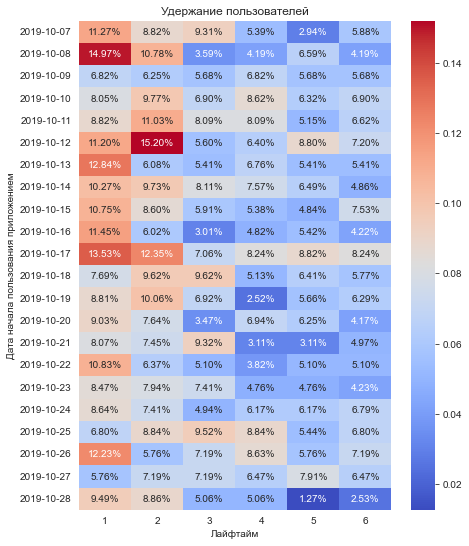

In [97]:
# Удалим столбы с размером когорты и первым днем, чтобы визуализировать таблицу удержания
report = retention.drop(columns = ['cohort_size', 0])

plt.figure(figsize = (7,9))
sns.heatmap(report, annot=True, fmt='.2%', cmap= 'coolwarm')
plt.title('Удержание пользователей')
plt.xlabel('Лайфтайм')
plt.ylabel('Дата начала пользования приложением')

Text(0, 0.5, 'Удержание')

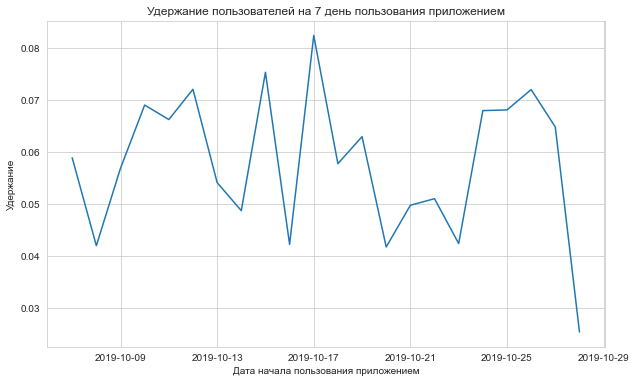

In [98]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data = retention.reset_index(),
    x = 'dt',
    y = 6
)
plt.title('Удержание пользователей на 7 день пользования приложением')
plt.xlabel('Дата начала пользования приложением')
plt.ylabel('Удержание')

In [99]:
retention[6].mean()

0.05774334111779655

**Вывод:**

 - Удержание пользователей стабильно снижается к 7 дню пользования, оно варьируется от 2% до 7%. Среднее удержание к 7 дню - 5.7%.
 - Наибольшее удержание к концу первой недели пользования наблюдается у пользователей, которые впервые воспользовались приложением с 10 по 12 октября, 15 и 17 октября, во вторую половину месяца удержание снижается вплоть до 14 октября.

### Удержание с разбивкой по типам событий

In [100]:
# Функция для визуализации удержания с разбивкой пользователей по типам событий
### (название события, строка расположения графика, столбец расположения графика, название)
def show_event_retention(event, ax1, ax2, title):
    
    # Выделим из данных только те, которые соответствуют определенному событию
    event_data = data[data['event_name'] == event]
    
    # Найдем id уникальных пользователей, которые совершили данное события
    event_profiles = event_data['user_id'].unique()
    
    # Выделим этих пользователей из датасета с профилями пользователей
    event_profiles_df = profiles.query('user_id in @event_profiles')
    
    # Найдем удержание
    raw, retention = get_retention(event_profiles_df, event_data, observation_date, 7, dimensions=['dt'])
    
    # Удалим столбцы с размером когорты и 1 днем
    report = retention.drop(columns = ['cohort_size', 0])
    
    # Построим тепловую карту
    sns.heatmap(report, annot=True, fmt='.2%', cmap= 'coolwarm', ax = axes[ax1,ax2]).set_title(title)

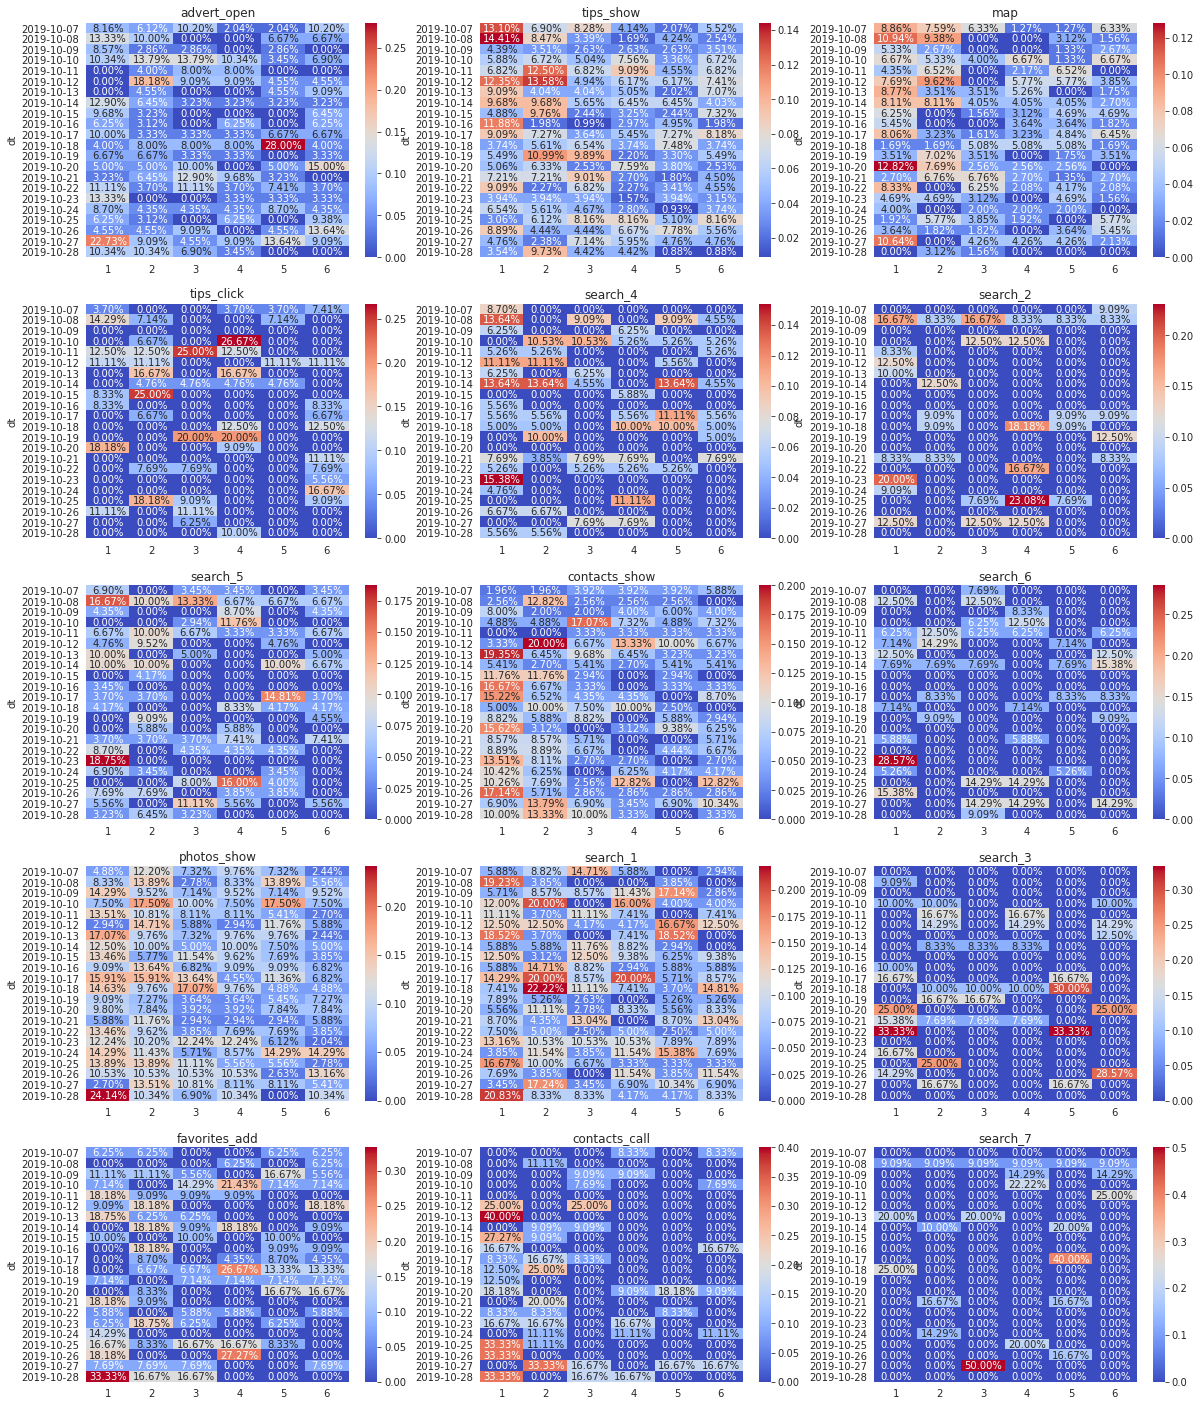

In [48]:
# Переменная с названиями событий
event_names = data.event_name.unique()

# Размер и разметка графика
fig, axes = plt.subplots(5, 3, figsize=(20,25))

for i in range(len(event_names)):
    
    # Я ввожу дополнительную переменную k чтобы правильно разместить графики в сетке
    k = i / 3
    
    if k<1:
        show_event_retention(event_names[i], 0, i, event_names[i])
        
    if k >= 1 and k < 2:
        show_event_retention(event_names[i], 1, i-3, event_names[i])
        
    if k >=2 and k < 3:
        show_event_retention(event_names[i], 2, i-6, event_names[i])  
        
    if k >=3 and k<4:
        show_event_retention(event_names[i], 3, i-9, event_names[i])
        
    if k>=4:
        show_event_retention(event_names[i], 4, i-12, event_names[i])      

**Вывод:** Наибольшее удержание показывают группы пользователей, которые совершли следующие действия: просмотр рекомендованных объявлений(tips_show), открытие карты(map), показ контактов(contac_show), просмотр изображений(photos_show) и поиск(search_1). Рассмотрим эти события подробнее:

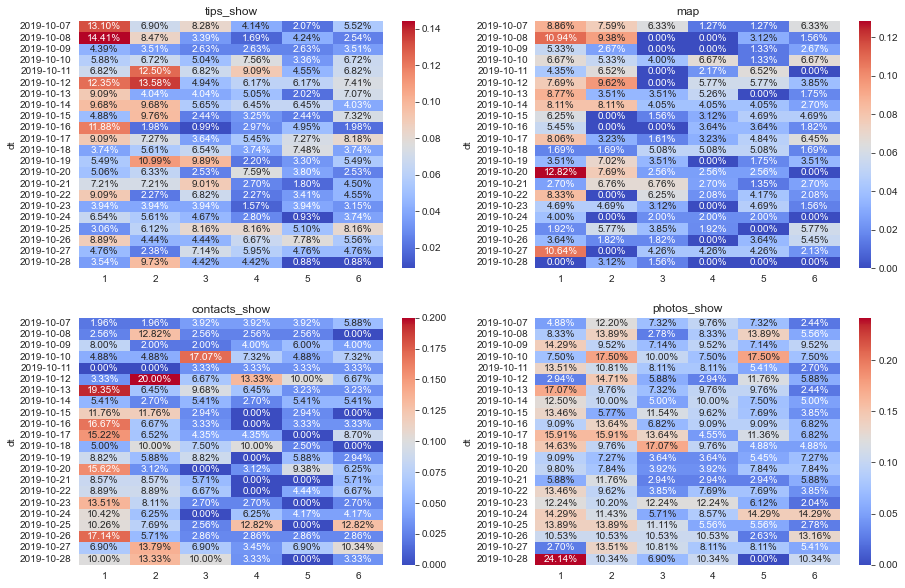

In [101]:
events = ['tips_show', 'map', 'contacts_show', 'photos_show']

fig, axes = plt.subplots(2, 2, figsize=(15,10))

for i in range(len(events)):
    k = i / 2
    
    if k<1:
        show_event_retention(events[i], 0, i, events[i])
        
    if k >= 1:
        show_event_retention(events[i], 1, i-2, events[i])

**Вывод:**
 - Наиболее стабильное удержание показывают пользователи, которые открывают изображения объявлений. В некоторых когортах удержание доходит до 14% на 7 день, при этом в другие этапы лайфтайма удержание также достаточно высокое.
 - Среди пользователкй, которые открывали контакты продавца, удержание непостоянно. В некоторых когортах оно достигает 0%, однако есть и те, в которых оно 10% и 12%. Если сравнивать с общим удержанием, то оно действительно выше.

### Вывод:

 - Удержание всех пользователей стабильно снижается к 7 дню пользования, оно варьируется от 2% до 7%.
 - К концу(после 20 октября) месяца когорты показывают более высокое удержание.
 - Удержание выше среди пользователей, которые открывали контакты продавца.
 
 ---

## Пользователи по времени, проведенному в приложении

### По времени с установки приложения

In [102]:
# Добавим в data информацую о дате первого посещения приложения
data = data.merge(profiles[['user_id', 'first_ts']], on='user_id')

# Найдем дату последнего посещения сайта
last_action = (
    data.sort_values(by=['user_id', 'event_time'])
    .groupby('user_id')
    .agg({'event_time':'last'})
    .rename(columns={'event_time':'last_ts'})
    .reset_index()
)

# Прицепим эту информацию к профилям пользователей
profiles = profiles.merge(last_action, on='user_id')

# Найдем лайфтайм каждого пользователя
profiles['lifetime'] = (profiles['last_ts'] - profiles['first_ts']).dt.days

Text(0, 0.5, 'Количество пользователей')

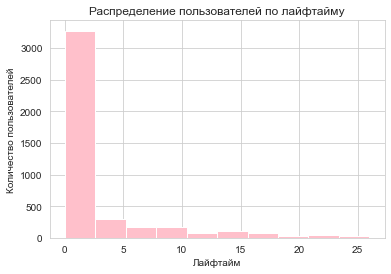

In [103]:
profiles['lifetime'].hist(color='pink')
plt.title('Распределение пользователей по лайфтайму')
plt.xlabel('Лайфтайм')
plt.ylabel('Количество пользователей')

Как можно видеть на гистограмме, есть очень много пользователей, которые заходили в приложение только один раз(или в течение 1 дня). Также есть пользователи, которые пользуются приложением примерно 10 дней и более.

In [104]:
profiles.lifetime.median()

0.0

In [105]:
profiles.lifetime.mean()

2.4372233869089217

Рассмотрим пользователей, лайфтайм которых более или равен 1 дню:

In [108]:
profiles.query('lifetime != 0')['lifetime'].median()

6.0

In [109]:
profiles.query('lifetime != 0')['lifetime'].mean()

7.648391812865497

В среднем пользователи из выборки пользуются приложением 2 дня.

### По длительности сессии в течение дня

In [110]:
# Найдем длительность сессии в течение дня
data['session_duration'] = data['session_end'] - data['session_start']

In [111]:
data.groupby('session_duration').agg({'user_id':'nunique'})

,user_id
session_duration,
0 days 00:00:00,729
0 days 00:00:01,9
0 days 00:00:02,10
0 days 00:00:03,20
0 days 00:00:04,12
...,...
0 days 23:00:03,1
0 days 23:06:13,1
0 days 23:27:06,1


У нас есть несколько пользователей, которые провели на сайте 0 секунд. Скорее всего это пользователи, которые открыли приложение и сразу же его закрыли, учитывать эти данные в анализе не имеет смысла.

Также есть пользователи, которые провели на сайте несколько часов(даже более 23 часов), скорее всего это пользователи, которые пользовались приложением несколько раз в течение дня.

В дальнейшем я рассмотрю, как это влияет на совершение целевого действия

## Совершение целевого действия

In [112]:
# Выделим данные только о событии показ контактов
contacts_show_data = data[data['event_name'] == 'contacts_show']

# Остальные данные
other_data = data[data['event_name'] != 'concatcs_show']

# Найдем id пользователей, которые совершали целевое действие
contacts_show_id = data[data['event_name'] == 'contacts_show']['user_id'].unique()

# Выделим профили этих пользователей
contacts_show_profiles = profiles.query('user_id in @contacts_show_id')

# Профили остальных пользователей
other_profiles = profiles.query('user_id not in @contacts_show_id')

### Лайфтайм

Text(0.5, 0.98, 'Соотношение количества пользователей по лайфтайму для совершивших и не совершивших целевое действие')

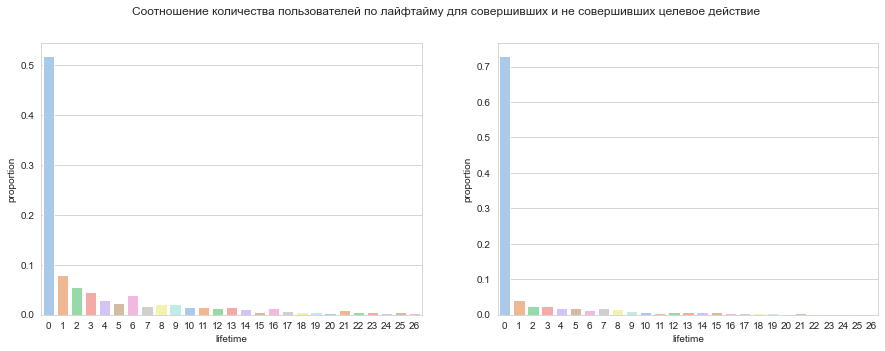

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Выделим переменную, в которо будут данные о профилях пользователей
users = [contacts_show_profiles, other_profiles]

for i in range(len(users)):
    
    # Сгруппируем по лайфтайму и найдем кол-во пользователей
    report = users[i].groupby('lifetime').agg({'user_id':'nunique'}).reset_index()
    
    # Добавим переменную с отношением кол-ва пользователей в определенный день лайфтайма ко всем пользователям
    report['proportion'] = report['user_id'] / report['user_id'].sum()
    
    sns.barplot(data=report, y = 'proportion', x = 'lifetime', ax = axes[i], palette = 'pastel')
    
plt.suptitle('Соотношение количества пользователей по лайфтайму для совершивших и не совершивших целевое действие')

**Вывод:**
 - Как мы видим на графиках, среди пользователей, которые совершили целевое действие, примерно 50% - это "пользователи-однодневки", в то время как среди пользователей, которые это действие не совершали, "однодневки" составляют более 70%.
 - В группе совершивших целевое действие больше пользователей, которые пользуются приложением более недели, чем в группе тех, кто его не совершал.
 
 Как мне кажется, стоит обратить внимание на удержание этих пользователей.

### Удержание

In [114]:
# Найдем удержание для пользователей в группе с целевым действием
raw1, retention_success = get_retention(contacts_show_profiles, contacts_show_data, observation_date, 7, dimensions=['dt'])

# Удержание для остальных пользователей
raw2, retention_fail = get_retention(other_profiles, other_data, observation_date, 7, dimensions=['dt'])


Text(0.5, 1.0, 'Не совершавшие целевое действие')

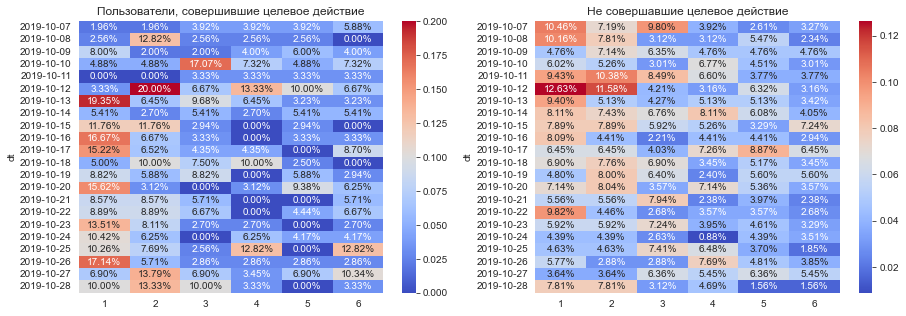

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.heatmap(
    retention_success.drop(columns=['cohort_size', 0]),
    annot=True, fmt = '.2%',
    cmap= 'coolwarm',
    ax = axes[0]
).set_title('Пользователи, совершившие целевое действие')

sns.heatmap(
    retention_fail.drop(columns=['cohort_size', 0]),
    annot=True,
    fmt = '.2%',
    cmap= 'coolwarm',
    ax = axes[1]
).set_title('Не совершавшие целевое действие')



In [116]:
print('Среднее удержание пользователей на 7 день в группе, совершивших целевое действие: {:.2%}'.format(retention_success[6].mean()))

print('Среднее удержание пользователей на 7 день в группе, не совершавших целевое действие: {:.2%}'.format(retention_fail[6].mean()))




Среднее удержание пользователей на 7 день в группе, совершивших целевое действие: 4.80%
Среднее удержание пользователей на 7 день в группе, не совершавших целевое действие: 3.71%


**Вывод:**
 - Среднее удержание пользователей в группе совершивших целевое действие выше практически на один процент. 
 - Как мне кажется, что чем дольше пользователь пользуется приложением, тем выше вероятность того, что он в конечном итоге приобретет товар. 

### Источник 

Посмотрим, как распределяются источники прихода пользователей для групп с целевым действием и без него.

Text(0.5, 0.98, 'Соотношение количества пользователей по типу источника для совершивших и не совершивших целевое действие')

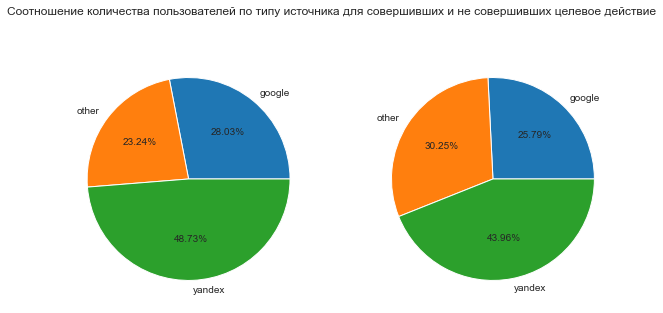

In [117]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))

for i in range(len(users)):
    
    # Сгруппируем даные по источнику и найдем количество пользователей
    report = users[i].groupby('source').agg({'user_id':'count'}).reset_index()
    
    # Найдем отношения кол-ва пользователей из опр. источника ко всем пользователям
    report['perc'] = report['user_id'] / report['user_id'].sum()
    
    axs[i].pie(report['perc'], labels = report['source'], autopct='%.2f%%')

    
plt.suptitle('Соотношение количества пользователей по типу источника для совершивших и не совершивших целевое действие')

**Вывод:** Как мне кажется, особой зависимости между каналом, через который пользователь нашел приложение, и конверсией в целевое действие нет.

### Количество действий

In [118]:
# Выделим в данных только действия тех пользователей, которые совершали целевое действие
data_success = data.query('user_id in @contacts_show_id')

# И остальных
data_fail = data.query('user_id not in @contacts_show_id')

In [119]:
# Найдем среднее кол-во действий на пользователя в первой группе
data_success['event_name'].count() / data_success['user_id'].nunique()

27.723751274209988

In [120]:
# И во второй
data_fail['event_name'].count() / data_fail['user_id'].nunique()

14.190821256038648

**Вывод:** Как мы видим, пользователи, которые совершают целевое действие, совершают в принципе больше действий в мобильном приложении практически в 2 раза.

### Время между распространенными событиями

В качестве распространенного события я возьму использование функции поиска.

In [121]:
report = data

# Уберем данные, в которых длительность сессии превышает 1 час и равен 0 сенкуд
report = report[report['session_duration'] < '0 days 01:00:00']
report = report[report['session_duration'] > '0 days 00:00:00']


# Найдем время от начала сессии до совершения события
report['time_to_event'] = report['event_time'] - report['session_start']

# Выделим данные о событии поиска
report1 = report[report['event_name'] == 'search_5']

# Раздлим на три равные группы
pd.qcut(report1['time_to_event'], q=3)

88                   (0 days 00:00:23, 0 days 00:53:04]
218      (-1 days +23:59:59.999999999, 0 days 00:00:07]
383      (-1 days +23:59:59.999999999, 0 days 00:00:07]
1131     (-1 days +23:59:59.999999999, 0 days 00:00:07]
1142     (-1 days +23:59:59.999999999, 0 days 00:00:07]
                              ...                      
73569                (0 days 00:00:23, 0 days 00:53:04]
73658    (-1 days +23:59:59.999999999, 0 days 00:00:07]
73715    (-1 days +23:59:59.999999999, 0 days 00:00:07]
73845    (-1 days +23:59:59.999999999, 0 days 00:00:07]
74088                (0 days 00:00:23, 0 days 00:53:04]
Name: time_to_event, Length: 709, dtype: category
Categories (3, interval[timedelta64[ns], right]): [(-1 days +23:59:59.999999999, 0 days 00:00:07] < (0 days 00:00:07, 0 days 00:00:23] < (0 days 00:00:23, 0 days 00:53:04]]

По времени от предположительного начала сессии до поиска пользователи делятся на 3 равные группы: первая группа открывает поиск в течение 7 секунд, вторая в течение 23 секунд и третья - в течение 53 минут.

Рассмотрю их конверию в совершение целевого действия

In [122]:
# Выделим три группы в отдельные переменные
report_less = report1[report1['time_to_event'] < '0 days 00:00:07']
report_medium = report1[(report1['time_to_event'] >= '0 days 00:00:07') & (report1['time_to_event'] < '0 days 00:00:23')]
report_more = report1[report1['time_to_event'] >= '0 days 00:00:22']

reports = [report_less, report_medium, report_more]

# Отобразим конверсию в целевое действие в этих группах
for el in reports:
    print(el.query('user_id in @contacts_show_id').user_id.count() / el.user_id.nunique())




0.19487179487179487
0.11059907834101383
0.1477832512315271


**Вывод:** Таким образом, получается, что пользователи, которые пользуются поиском в течение 6 секунд обладают большей конверсией в просмотр контактов, что кажется вполне логичным.

### Вывод:

 - В ходе исследования можно заметить зависимость между временем пользования приложением и совершением целевого действия. Пользователи охотнее совершают целевое действие, если они пользуются приложением более 1 дня. 
 - Среди пользователей, которые совершили целевое действие, наблюдается более высокое удержание.
 - Я не заметила сильной зависимости между источником прихода пользователя и совершением целевого действия. 
 - Пользователи, которые совершают целевое действие, совершают в среднем в 2 раза больше действий в приложении, чем остальные 

**Вывод 2.0:**

 - В приложение склонны часто возвращаться пользователи, которые просматривали контакты продавца, фотографии объявлений и открывали карту. Среди этих пользователей наблюдается более высокое удержание.
 - Аналогично целевое событие чаще совершают пользователи, которые дольше пользуются приложением(более одного дня) и которых выше удержание. 
 - Также целевое действие чаще совершают пользователи, которые в целом совершают больше действий в приложении.
 - Пользователи различаются по группам на основе времени, которое проходит с первого использования мобильного приложения. Стоит отметить, что конверсия в целевое действие выше среди пользователей, которые пользуются поиском в течение 7 секунд после начала сессии.

## Проверка статистических гипотез

In [126]:
# Функция для проверки равенства долей
import math as mth

def check_proportion(successes1, successes2, trials1, trials2):
    
    alpha = 0.05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2)
    )
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 


### Сравнение конверсии в просмотры контактов с разбивкой по источнику

**Нулевая гипотеза:** Пользователи пришедшие из yandex и из google демонстрируют одинаковую конверсию в просмотры контактов.

**Альтернативная гипотеза:** Конверсия разная.

In [128]:
# Найдем кол-во уникальных пользователей, которые совершили целевое действие с разбивкой по источнику
yandex_success = contacts_show_profiles[contacts_show_profiles['source'] == 'yandex']['user_id'].nunique()
google_success = contacts_show_profiles[contacts_show_profiles['source'] == 'google']['user_id'].nunique()

# Найдем кол-во уникальных пользователей с разбивкой по источнику
yandex_profiles = profiles[profiles['source'] == 'yandex']['user_id'].nunique()
google_profiles = profiles[profiles['source'] == 'google']['user_id'].nunique()


In [129]:
check_proportion(yandex_success, google_success, yandex_profiles, google_profiles)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** Нам не удалось отвергнуть гипотезу о том, что пользователи демонстрируют одинаковую конверсию.

### Сравнение конверсии по времени, проведенному на сайте

Пользователи проводят на сайте разное количество времени. Как мне кажется, конверсия в целевое действие тоже разная в зависимости от времени, проведенному на сайте.

In [133]:
# Добавим в таблицу информацию о совершении целевого действия

data.loc[data['event_name'] == 'contacts_show', 'success'] = 1
data.loc[data['event_name'] != 'contacts_show', 'success'] = 0

В таблице data указана информация о каждом действии пользователя, поэтому я соберу отдельную таблицу, в которой будет информация о длительности сессии для каждого пользователя, а также совершил ли он целевое действие.

In [134]:
sessions = (
    data.sort_values(by = ['user_id', 'session_duration'])
    .groupby(['user_id', 'session_duration'])
    .agg({'success':'sum'})
    .reset_index()
)

# Пользователь мог несколько раз совершить целевое действие, поэтому, если в данном столбцу значение больше 1,
# то мы заменим его на 1
sessions.loc[sessions['success'] > 0, 'success'] = 1

Для рассмотрения мы возьмем только пользователей, у которых время, проведенное на сайте менее 1 часа и более 0 секунд:

In [135]:
sessions = sessions[sessions['session_duration'] < '0 days 01:00:00']

sessions = sessions[sessions['session_duration'] > '0 days 00:00:00']


In [136]:
# Разделим данные на 2 равные группы 
pd.qcut(sessions['session_duration'], q=2)


0       (0 days 00:00:00.999999999, 0 days 00:09:32]
1                 (0 days 00:09:32, 0 days 00:59:54]
2                 (0 days 00:09:32, 0 days 00:59:54]
3                 (0 days 00:09:32, 0 days 00:59:54]
5       (0 days 00:00:00.999999999, 0 days 00:09:32]
                            ...                     
7511    (0 days 00:00:00.999999999, 0 days 00:09:32]
7512              (0 days 00:09:32, 0 days 00:59:54]
7513              (0 days 00:09:32, 0 days 00:59:54]
7514              (0 days 00:09:32, 0 days 00:59:54]
7515              (0 days 00:09:32, 0 days 00:59:54]
Name: session_duration, Length: 5029, dtype: category
Categories (2, interval[timedelta64[ns], right]): [(0 days 00:00:00.999999999, 0 days 00:09:32] < (0 days 00:09:32, 0 days 00:59:54]]

In [138]:
# Найдем разделим пользователей, совершивших целевое действие на группы по времени, проведенному на сайте
less_success = sessions[(sessions['session_duration'] < '0 days 00:09:32') & sessions['success'] == 1]['user_id'].nunique()
more_success = sessions[(sessions['session_duration'] >= '0 days 00:09:32') & sessions['success'] == 1]['user_id'].nunique()

# Аналогично разделим всех пользователей
less = sessions[sessions['session_duration'] < '0 days 00:09:32']['user_id'].nunique()
more = sessions[sessions['session_duration'] >= '0 days 00:09:32']['user_id'].nunique()



---

**Нулевая гипотеза:** Пользователи, пользовавшиеся приложением менее 9 минут 32 секунд, и пользователи, пользовавшиеся приложением больше этого времени, демонстрируют одинаковую конверсию в просмотр контактов.

**Альтернативная гипотеза:** Конверсия разная.

In [139]:
check_proportion(less_success, more_success, less, more)

p-значение:  0.0002924697267359111
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** Отвергаем нулевую гипотезу о том, что пользователи с разной длительностью сессий демонстрируют одинаковую конверсию. Пользователи демонстрируют разную конверсию. 

## Вывод:

- В ходе исследования была проведена предобработка данных: дубликатов и пропущенных значений обнаружено не было, были изменены типы данных, а также добавлены новые значения(начало и окончание сессии, длительность сессии).
 - В ходе исследовательского анализа данных было обнаружено, что активность пользователей в течение месяца увеличивается, в течение недели наблюдается спад активности к выходным.
 - Наиболее частое событие - показ рекомендованных объявлений, целевое событие(просмотр контактов) совершают примерно 23% пользователей. Медианное количество событий на пользователя - 9, среднее - 17.
 - Наибольшее количество пользователей скачивают приложение по ссылке с Яндекса(45%), из Google - 26% и из других источников - 28%.
 - Удержание пользователей стабильно снижается к 7 дню пользования приложением, в среднем оно составляет 5.7%. Удержание выше среди пользователей, которые совершали целевое действие.
 - Была обнаружена зависимость между временем пользования приложением и совершением целевого действия: пользователи, которые дольше пользуются приложением, охотнее совершают целевое действие.
 - Удержание в группе пользователей, совершивших целевое действие, выше примерно на 1%, чем среди тех, кто его не совершал.
 - Источник, через который пользователь скачал приложение, практически не влияет на совершение целевого действия.
 - Пользователи, которые совершают целевое действие, совершают в среднем в 2 раза больше действий в приложении, чем остальные.
 
 
 - В ходе проверки статистических гипотез было обнаружено, что нет статистической разницы в конверсии между пользователями, пришедшими из Яндекса и Google.
 - Также было обнаружено, что есть статистическая разница между группами с разной длительностью сессии.

**Рекомендации:** На основании моего исследования я могу предложить обратить внимание на удержание пользователей. Чем дольше пользователь пользуется приложением, тем выше вероятность того, что он совершит целевое действие.